### Lab 2. 

#### Task 1: Simulation of Continuous Random Variables (Inverse Transform Method)

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy import simplify
from sympy.abc import x, y
from sympy.calculus.util import continuous_domain
from scipy.stats import norm, chi2
from IPython.display import HTML, display


In [92]:
inverse_function = ""
distribution_expression = ""
plt.rcParams["figure.figsize"] = (10, 30)
number_of_dots = 1000
gamma = 0.95
hypothesis_error_value = 0.05 


def display_table(data):
    html = "<table style='border-collapse: collapse; width: 100%;'>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td style='border: 1px solid black; padding: 8px;'><h4>%s</h4></td>" % (field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))


#### Linear Congruential Method

In [93]:
class LinearCongruentialGenerator:
    seed = 42
    alpha = 1664525
    c = 1013904223
    m = 2 ** 32
    x_current = seed
     
    @staticmethod
    def random():
        LinearCongruentialGenerator.x_current = (LinearCongruentialGenerator.alpha * LinearCongruentialGenerator.x_current + LinearCongruentialGenerator.c) % LinearCongruentialGenerator.m
        return LinearCongruentialGenerator.x_current / LinearCongruentialGenerator.m

#### Find inverse function

In [94]:
# Define symbols
x, y = symbols('x y')
gamma = 0.95  # Confidence level
number_of_tests = 30  # Example number of tests
generator = LinearCongruentialGenerator()  # Assuming CustomGenerator is defined elsewhere

In [95]:
def find_inverse_function(input_text): 
    global inverse_function
    ex = sympify(input_text)
    results = solve(ex - y, x)  # Solve for x in terms of y
    
    for result in results:
        is_continuous = continuous_domain(result, y, S.Reals).is_proper_superset(Interval(0, 1))
        derivative = diff(result, y)
        derivative_positive = solve(derivative > 0, y, domain=S.Reals)
        
        if derivative_positive and is_continuous:
            print(f"Inverse function: {result}")
            inverse_function = lambdify(y, result)
            return  # Exit after finding the first valid inverse function

    print("Inverse function not found")

#### Generating data

In [96]:
def generate_func_data(amount):
    global inverse_function
    return [inverse_function(generator.random()) for _ in range(amount)]  # List comprehension for efficiency

#### Calculating means

In [97]:
def calculate_sample_mean(sample):
    return sum(sample) / len(sample)

def calculate_theoretical_mean(func, limits):
    return integrate(x * func, (x, limits[0], limits[1]))

#### Calculating variances

In [98]:
def calculate_sample_variance(sample):
    sample_mean = calculate_sample_mean(sample)
    variance = sum((x - sample_mean) ** 2 for x in sample) / len(sample)
    return variance

def calculate_theoretical_variance(func, limits, theoretical_mean):
    integral = integrate(x ** 2 * func, (x, limits[0], limits[1]))
    theoretical_variance = integral - theoretical_mean ** 2
    return theoretical_variance.evalf()

In [99]:
def get_delta(offset):
    t = norm.ppf(gamma / 2 + 0.5)  # Quantile
    return t * offset / np.sqrt(number_of_tests)  # Margin of Error

def get_offset_delta(test_offset): 
    alphas = ((1 - gamma) / 2, (1 + gamma) / 2)  # Boundaries for chi-squared quantiles
    chis = chi2.isf(alphas, number_of_tests - 1) 
    temp = np.sqrt(number_of_tests - 1) * test_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))  # Return confidence intervals

#### Continuous random variable

In [100]:
func = input("Your function:\n")
find_inverse_function(func)


Inverse function: sqrt(4*y + 1)/2 + 1/2


In [101]:
number_of_tests = int(input("Amount of random values:\n"))

func_data = generate_func_data(number_of_tests)

limits = (inverse_function(0), inverse_function(1))

In [102]:
ex = simplify(func)
derivate = diff(ex, x)

sample_mean = calculate_sample_mean(func_data) 
sample_variance = calculate_sample_variance(func_data) 
sample_std_deviation = sqrt(sample_variance)

theoretical_mean = calculate_theoretical_mean(derivate, limits)
theoretical_variance = calculate_theoretical_variance(derivate, limits, theoretical_mean)
theoretical_std_deviation = sqrt(theoretical_variance)

In [103]:
# Prepare data for display
data1 = [
    ['Description', 'Sample value', 'Theoretical value'],
    ["Mean", sample_mean, theoretical_mean],
    ["Variance", sample_variance, theoretical_variance],
    ["Deviation", sample_std_deviation, theoretical_std_deviation]
]

# Display the table
display_table(data1)

Description,Sample value,Theoretical value
Mean,1.3491713791601878,1.34836165729158
Variance,0.03014907255383261,0.0302824984374856
Deviation,0.173634882883114,0.174018672669015


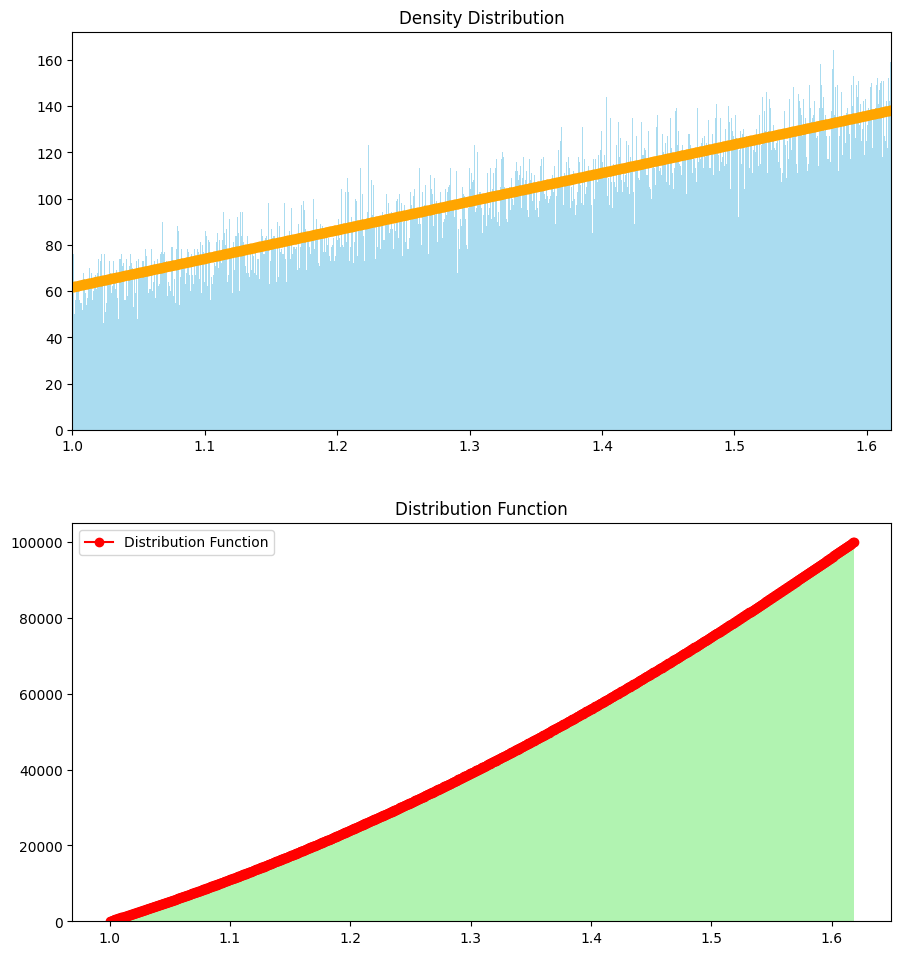

In [104]:
# Define the histogram
hist, bins = np.histogram(func_data, bins=number_of_dots, range=limits)
plt.subplot(6, 1, 1)
plt.tight_layout(pad=5)
plt.hist(func_data, color="skyblue", bins=number_of_dots, range=limits, alpha=0.7)
plt.xlim(limits)
plt.title("Density Distribution")

# Build the derivative plot
derivative_expr = diff(ex, x)
length = (limits[1] - limits[0]) / number_of_dots  # step
dots = np.arange(limits[0] + length / 2, limits[1], length)  # points for derivative estimation
derivative = lambdify(x, length * number_of_tests * derivative_expr)
results = derivative(dots)  # Use vectorization

plt.plot(dots, results, marker='o', color="orange", label='Derivative')

# Cumulative frequency histogram
extra_hist = np.cumsum(hist)  # Use cumsum for accumulation
plt.subplot(6, 1, 2)
plt.bar(bins[:-1], extra_hist, width=length, align="edge", color='lightgreen', alpha=0.7)

# Distribution function
distribution_function = lambdify(x, number_of_tests * ex)
distribution_dots = np.arange(limits[0] + length, limits[1] + length / 10, length)
distribution_results = distribution_function(distribution_dots)

plt.plot(distribution_dots, distribution_results, marker='o', color="red", label='Distribution Function')
plt.title("Distribution Function")
plt.legend()  # Add a legend to label the plots
plt.show()


In [105]:
delta = get_delta(theoretical_std_deviation)
offset_delta = get_offset_delta(sample_std_deviation)

In [106]:
# Calculate the square of the offset delta
val = np.square(offset_delta)

# Prepare the data for display
data = [
    ['Description', 'Expected Value', 'Variance'],
    ['Sample', sample_mean, sample_variance],
    ['Theoretical', theoretical_mean, theoretical_variance],
    ['Confidence Interval Start', sample_mean - delta, val[0]],
    ['Confidence Interval End', sample_mean + delta, val[1]]
]

# Display the table
display_table(data)

Description,Expected Value,Variance
Sample,1.3491713791601878,0.03014907255383261
Theoretical,1.34836165729158,0.0302824984374856
Confidence Interval Start,1.34809282007170,0.0298865432679567
Confidence Interval End,1.35024993824867,0.0304150923998112


In [107]:
# Calculate degrees of freedom
k = number_of_dots - 3  # Degrees of freedom (number_of_dots - 2 - 1)

# Calculate the critical value for the chi-squared distribution
critical_value = chi2.isf(hypothesis_error_value, k)

# Calculate the chi-squared statistic for the sample
normal_value = sum(np.square(hist[i] - results[i]) / results[i] for i in range(number_of_dots))

# Determine whether to accept or reject the hypothesis
result_for_print = "accept" if normal_value < critical_value else "reject"


In [108]:
# Prepare data for display
data1 = [
    ['Description', 'Value'],
    ["Critical Chi-squared", critical_value],
    ["Sample Chi-squared", normal_value],
    ["Hypothesis Acceptance", result_for_print]
]

# Display the table
display_table(data1)

Description,Value
Critical Chi-squared,1071.568999044425
Sample Chi-squared,951.641827241789
Hypothesis Acceptance,accept


#### Task 2. SIMULATION OF DISCRETE RANDOM VARIABLES (with a given distribution law)

In [109]:
inverse_function = ""
distribution_expression = ""
plt.rcParams["figure.figsize"] = (10, 30)
max_value1 = 40
gamma1 = 0.95
number_of_dots1 = 20
hypothesis_error_value1 = 0.05

In [110]:
generator1 = LinearCongruentialGenerator()

def get_random1():
    random_number = generator1.random()
    
    for i in range(max_value1):
        probability = p_prob1 * (1 - p_prob1) ** i
        
        if random_number < probability:
            return i + 1
        
        random_number -= probability
        
    return max_value1

In [111]:
def get_random_data():
    result = []
    
    for i in range(number_of_tests1):
        result.append(get_random1())
    
    return result

In [112]:
def get_mean(data):
    return sum(data) / number_of_tests1

def get_theoretical_mean():
    return 1 / p_prob1

In [113]:
def get_theoretical_variance():
    return (1 - p_prob1) / np.square(p_prob1)

def get_variance(data, mean):
    result = 0
    
    for item in data:
        result += (item - mean) ** 2
        
    return result / number_of_tests1


In [114]:
def get_delta1(offset):
    t = norm.ppf(gamma1 / 2 + 0.5)
    return t * offset / np.sqrt(number_of_tests1)

def get_offset_delta1(test_offset):
    alphas = ((1 - gamma1) / 2, (1 + gamma1) / 2)
    chis = (chi2.isf(alphas, number_of_tests1 - 1))
    corrected_offset = sqrt((test_offset ** 2) * number_of_tests1 / (number_of_tests1 - 1))
    temp = np.sqrt(number_of_tests1 - 1) * corrected_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))


In [115]:
# Prompt the user for input
number_of_tests1 = int(input("Enter the number of values to be generated:\n"))
p_prob1 = float(input("Enter the probability:\n"))

In [116]:
data = get_random_data()
mean = get_mean(data)
theor_mean = get_theoretical_mean()
variance = get_variance(data, mean)
teoretical_variance = get_theoretical_variance()
standard_deviation1 = sqrt(variance)
theoretical_standard_deviation1 = sqrt(theoretical_variance)
deltaone = get_delta1(theoretical_standard_deviation1)
offset_delta1 = get_offset_delta1(standard_deviation1)

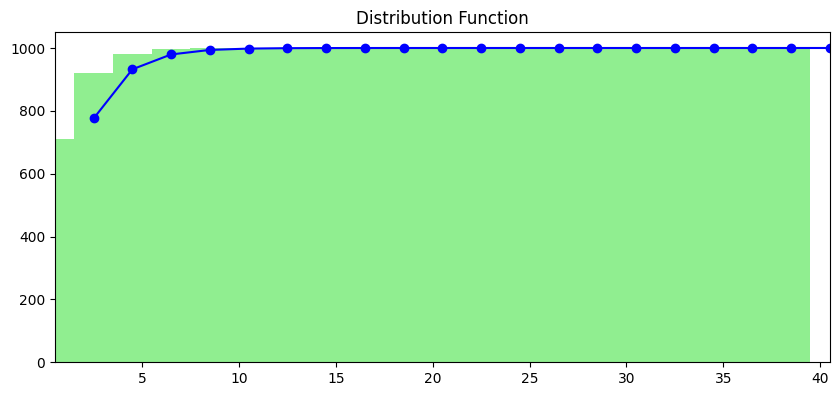

In [117]:
# Define limits for the histogram
limits = (0.5, max_value1 + 0.5)

# Create histogram
hist, bins = np.histogram(data, bins=number_of_dots1, range=limits)

# Calculate length of each bin
length = max_value1 / number_of_dots1

# Generate dot positions
dots = np.arange(0.5 * (length + 1), max_value1 + length / 2, length)

# Define the derivative function
derivative = lambdify(x, integrate(number_of_tests1 * p_prob1 * ((1 - p_prob1) ** (x - 1)), (x, x - length / 2, x + length / 2)))
results = list(map(derivative, dots))

# Create subplot for the cumulative histogram
plt.subplot(6, 1, 2)

# Create a cumulative histogram
extra_hist = hist.copy()
for i in range(1, len(hist)):
    extra_hist[i] += extra_hist[i - 1]

# Plot the cumulative histogram
ax = plt.gca()
ax.bar(bins[:-1], extra_hist, width=length, color="lightgreen")
plt.xlim(limits)

# Define the distribution function
distribution_function = lambdify(x, number_of_tests1 * (1 - (1 - p_prob1) ** x))
distribution_dots = np.arange(limits[0] + length, limits[1] + length / 10, length)

# Calculate distribution results
distribution_results = list(map(distribution_function, distribution_dots))

# Plot the distribution function
plt.plot(distribution_dots, distribution_results, marker='o', color="blue")
plt.title("Distribution Function")
plt.show()

In [118]:
k = number_of_dots1 - 2 - 1
critical_value = chi2.isf(hypothesis_error_value1, k)
normal_value = 0
    
for i in range(number_of_dots1):
    normal_value += np.square(hist[i] - results[i]) / results[i]
    

In [119]:
# Calculate the square of offset_delta1
val = np.square(offset_delta1)

# Prepare data for the table
data = [
    ['Description', 'Mathematical Expectation', 'Variance'],
    ['Sample', mean, variance],
    ['Theoretical', theor_mean, theoretical_variance],
    ['Confidence Interval Start', mean - deltaone, val[0]],
    ['Confidence Interval End', mean + deltaone, val[1]]
]

# Display the table
display_table(data)


Description,Mathematical Expectation,Variance
Sample,2.15,2.217500000000012
Theoretical,2.2222222222222223,0.0302824984374856
Confidence Interval Start,2.13921440911515,2.03723136980654
Confidence Interval End,2.16078559088485,2.42800566748804


In [120]:
# Determine the result of the hypothesis test
result_for_print = "accept" if normal_value < critical_value else "reject"

# Prepare data for the table
data1 = [
    ['Description', 'Value'],
    ["Critical Chi-Square", critical_value],
    ["Sample Chi-Square", normal_value],  
    ["Hypothesis Acceptance", result_for_print]
]
# Display the table
display_table(data1)


Description,Value
Critical Chi-Square,27.587111638275335
Sample Chi-Square,4.227946287500863
Hypothesis Acceptance,accept
